# Image Captioning
* Generating Captions for Images.

# Steps
* Data collection
* Understanding the data
* Data Cleaning
* Loading the training set
* Data Preprocessing — Images
* Data Preprocessing — Captions
* Data Preparation using Generator Function
* Word Embeddings
* Model Architecture
* Inference

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
import keras
import nltk
import collections
import pickle
import time
from keras.models import Sequential,Model
from keras.layers import *
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.optimizers import Adam
plt.style.use('seaborn')

Using TensorFlow backend.


In [2]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

captions = readTextFile("Flickr8k.token.txt").split("\n")[:-1]
print(len(captions))

40460


In [3]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

# Dictianory to Map each Image with the list of captions 

In [4]:
def getKeyNValue(x):
    key = (x.split("\t")[0]).split('.')[0]
    value = x.split("\t")[1]
    return key,value

In [5]:
descriptions = {}

for i in captions:
    key,value = getKeyNValue(i)
    
    if key not in descriptions:
        descriptions[key]  = []
    
    descriptions[key].append(value)

In [6]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

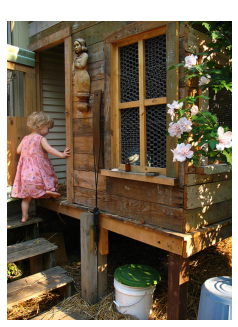

In [67]:
IMG_PATH = "Images/"
def showImage(img_name,title):
    img = plt.imread(IMG_PATH+img_name+".jpg")
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

showImage("1000268201_693b08cb0e"," ")

In [8]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [9]:
clean_text("A child in a pink dress is @ climbing up a set of stairs in an entry way 124.")

'child in pink dress is climbing up set of stairs in an entry way'

In [10]:
for key,value in descriptions.items():
    for i in range(len(value)):
        descriptions[key][i] = clean_text(value[i])

In [11]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

# Write Data in Text File

In [12]:
with open("description.txt",'w') as f:
    f.write(str(descriptions))

# Vocabulary

In [13]:
descriptions = None
with open("description.txt",'r') as f:
    descriptions = f.read()

descriptions = json.loads(descriptions.replace("'","\""))

In [14]:
all_words = []
for key in descriptions.keys():
    [all_words.append(word) for sent in descriptions[key] for word in sent.split()]
vocab = set(all_words)
print("Vocab Length : ",len(vocab))
print("Total Number Of Words : ",len(all_words))

Vocab Length :  8424
Total Number Of Words :  373837


# Sort according to the frequency & Filter Word from the vocab according to certain threshold frequency

In [15]:
counter = collections.Counter(all_words)
freq_cnt = dict(counter)

sorted_freq_cnt = sorted(freq_cnt.items(),key=lambda x:x[1],reverse = True)

threshold = 10
sorted_freq_cnt = [ x for x in sorted_freq_cnt if x[1]>threshold ]
all_words = [ x[0] for x in sorted_freq_cnt]
vocab_size= len(all_words)
print("All Words " ,len(all_words))

All Words  1845


In [16]:
with open("Flickr_8k.trainImages.txt",'r') as f:
    train_data = f.read()

with open("Flickr_8k.testImages.txt",'r') as f:
    test_data = f.read()

train_data = [x.split('.')[0] for x in (train_data.split("\n")[:-1])]
test_data  = [x.split('.')[0] for x in (test_data.split("\n")[:-1])]

In [17]:
train_desc = {}
for img_id in train_data:
    train_desc[img_id]=[]
    for i in range(len(descriptions[img_id])):
        changed_cap = "startseq"+descriptions[img_id][i]+"endseq"
        train_desc[img_id].append(changed_cap)

# Transfer Learning
* Images --> Features
* Text ---> Features

# Step - 1 Image Feature Extraction

In [18]:
model = ResNet50(weights="resnet50_weights_tf_dim_ordering_tf_kernels.h5",input_shape=(224,224,3))
#model.summary()

In [19]:
new_model = Model(model.input,model.layers[-2].output)

In [20]:
def preprocess_image(img_path):
    img = image.load_img(img_path,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


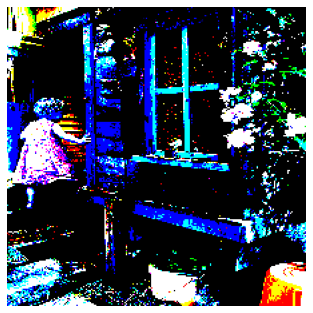

In [21]:
img = preprocess_image(IMG_PATH+"1000268201_693b08cb0e"+".jpg")
plt.imshow(img[0])
plt.axis('off')
plt.show()

In [22]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = new_model.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [23]:
start = time.time()
encoding_train = {}
for i,img_id in enumerate(train_data):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
end = time.time()
print("Total Time : ",(end-start))

Total Time :  1601.1644234657288


In [24]:
with open("encoding_train.pkl",'wb') as f:
    pickle.dump(encoding_train,f)

In [25]:
start = time.time()
encoding_test = {}
for i,img_id in enumerate(test_data):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
end = time.time()
print("Total Time : ",(end-start))

Total Time :  271.2916853427887


In [26]:
with open("encoding_test.pkl",'wb') as f:
    pickle.dump(encoding_test,f)

# Data Pre-Processing for Captions

In [27]:
word_to_idx = {}
idx_to_word = {}
for i,word in enumerate(all_words):
    idx_to_word[i+1] = word
    word_to_idx[word] = i+1
word_to_idx[1846] = 'startseq'
idx_to_word['startseq'] = 1846

word_to_idx[1847] = 'endseq'
idx_to_word['endseq'] = 1847

vocab_size = len(word_to_idx)+1

In [28]:
max_len = 0
for key in train_desc.keys():
    for cap in train_desc[key]:
        max_len = max(max_len,len(cap.split()))
print(max_len)

33


# Data Generator

In [29]:
def data_generator(train_desc,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y = [],[],[]
    
    n=0
    while True:
        for key,desc_list in train_desc.items():
            n+=1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    xi = pad_sequences([xi],max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    
                    X1,X2,y = [],[],[]
                    n=0

# Word Embedding

In [30]:
f = open("../Emoji Predictor/emojifier/services/emojifier/glove.6B.50d.txt",encoding='utf-8')

embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    embedding_word = np.array(values[1:],dtype='float')
    embedding_index[word] = embedding_word

f.close()

In [31]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix
embedding_matrix = get_embedding_matrix()
print(embedding_matrix.shape)

(1848, 50)


# Model Architecture

In [32]:
input_img_feature = Input(shape= (2048,))
inp_img1 = Dropout(0.3)(input_img_feature)
inp_imp2 = Dense(256,activation='relu')(inp_img1)

In [33]:
input_captions = Input(shape =(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [34]:
decoder1 = add([inp_imp2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

In [35]:
model = Model(inputs = [input_img_feature,input_captions],outputs = [outputs])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 33, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [36]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [37]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

# Training Of Model

In [38]:
def train(epochs,learning_rate,batch_size):
    steps = len(train_desc)//batch_size
    for i in range(epochs):
        generator = data_generator(train_desc,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save("model_{}".format(i)+".h5")

In [ ]:
epochs = 20
batch_size = 3
train(epochs,learning_rate,batch_size)

# Prediction

model_0


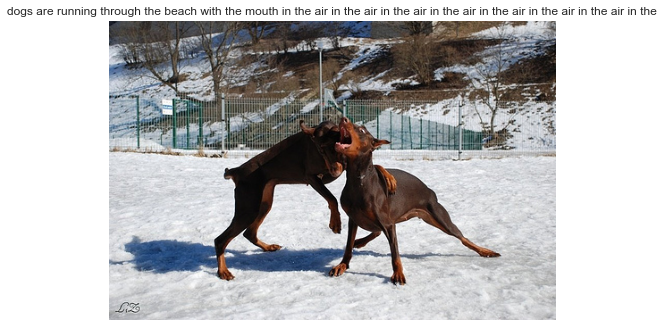

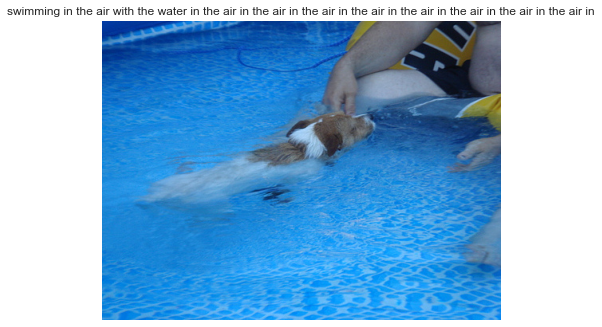

model_9


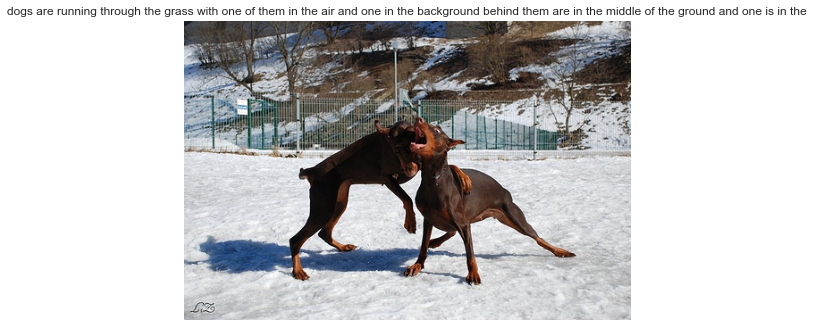

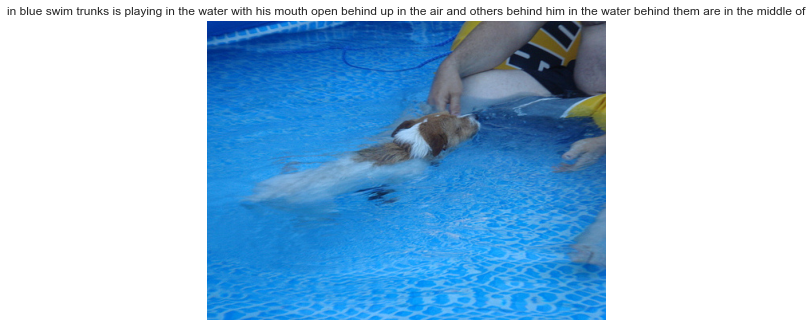

model_11


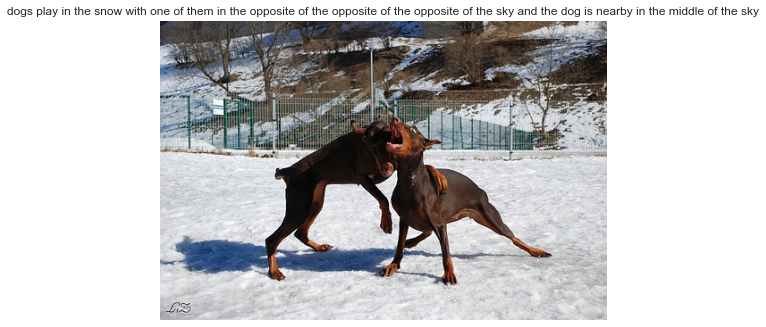

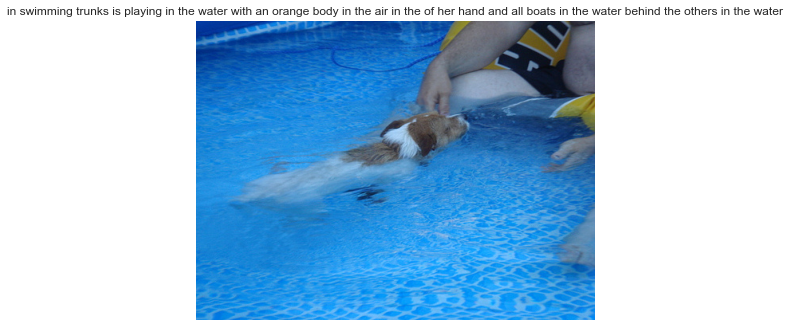

model_13


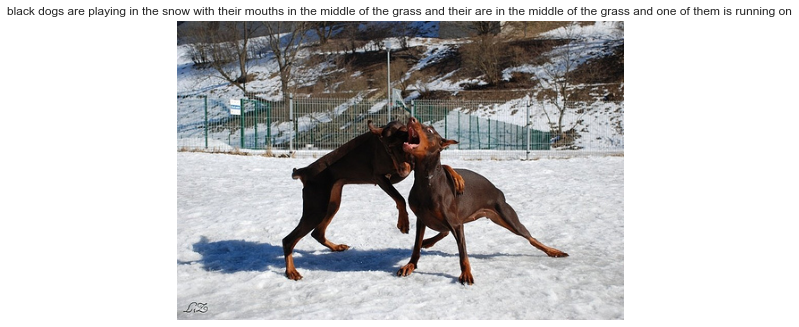

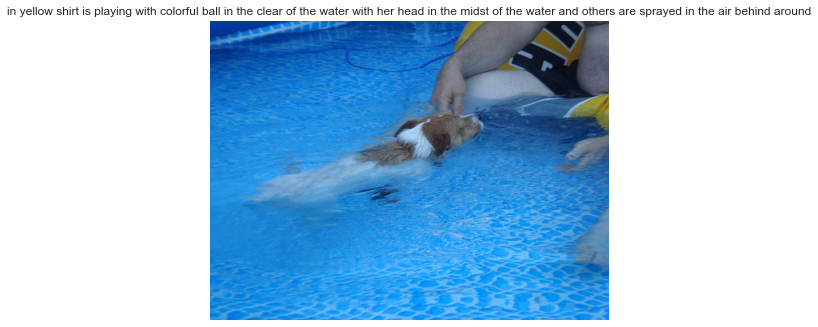

model_15


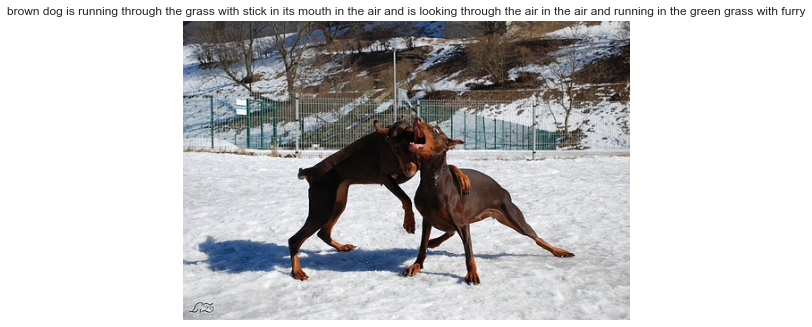

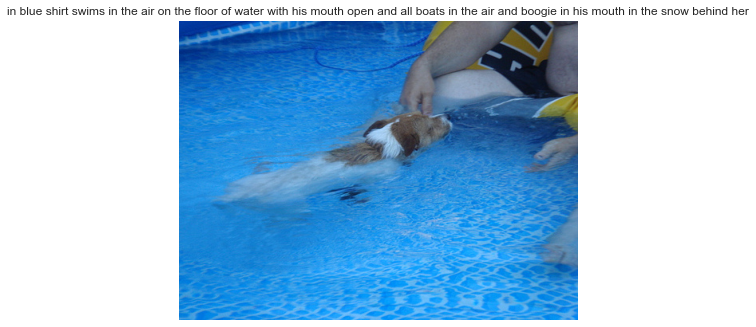

model_17


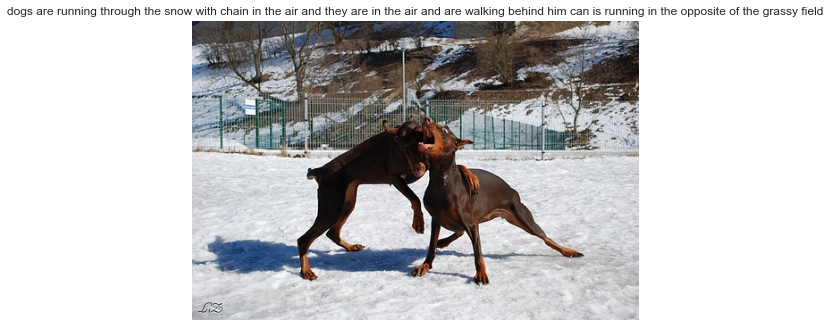

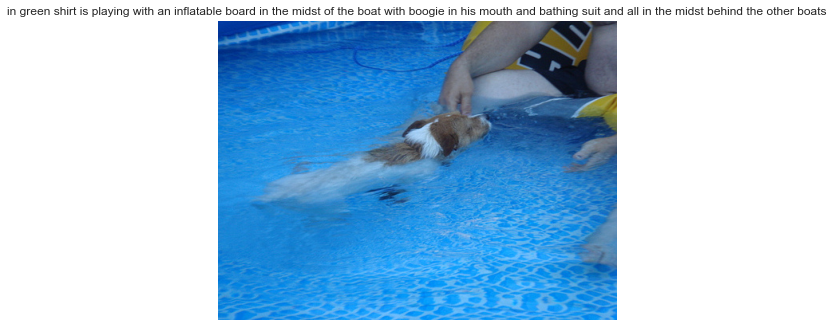

In [77]:
l = ["model_0","model_9","model_11","model_13","model_15","model_17"]
for i in l:
    print(i)
    model.load_weights(i+".h5")

    def predict_caption(photo):
        in_text = "startseq"
        for i in range(max_len):
            sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
            sequence = pad_sequences([sequence],maxlen=max_len,padding='post')

            y_pred = model.predict([photo,sequence])
            y_pred = y_pred.argmax()
    #         y_pred = np.random.randint(len(y_pred))
            word = idx_to_word[y_pred]
            in_text += ' ' + word

            if word == 'endseq':
                break
        final_caption = in_text.split()[1:-1]
        final_caption = ' '.join(final_caption)
        return final_caption

    for i in range(2):
        #no = np.random.randint(0,1000)
        img_name = list(encoding_test.keys())[i]
        photo_vector = encoding_test[img_name].reshape((1,2048))
        caption = predict_caption(photo_vector)
        showImage(img_name,title=caption)